<h2>TensorFlow Serving for AI Model Deployment</h2>
<img src='images/1.jpg'>
<p>
    <b>
    <ul>
        <li>What is Serving?</li>
        <li>TensorFlow Serving Introduction</li>
        <li>The Architecture Behind TensorFlow Serving</li>
        <li>An Approach to Model Serving</li>
        <li>Building A Classifier</li>
        <li>Fine-Tuning a Pre-trained ResNet-101 CNN Model</li>
        <li>Saving Model for TensorFlow Serving</li>
        <li>Serving Models with CPU Inference</li>
        <li>Serving Models with Docker for GPU Inference</li>
        <li>Building A Classifier API with Flask & TensorFlow Serving</li>
    </ul>
    </b>
    <br>
    <h3>What is Serving?</h3>
    <br>
    Is a technique to use or apply a model for inference after it has been trained, usually this technique involves having a server-client architecture and serving or exposing our trained models for inference.
    <br>
    <img src='images/request_simple_diagram.png'>
    <br>
    In this notebook, a classifier will be developed, certain specific access patterns will be applied for the models. On the client side there will be an input image which need to be classified, this image would need to be converted to an specific encoded format, wrap it in a specific JSON payload with headers and be sent to a web services/API which should typically be hosted on a server. The API call would invoke the pre-trained model to make the prediction and serve the inference result as a JSON response from the server to the client.
    <br>
    <h3>TensorFlow Serving Introduction</h3>
    <br>
    This is a brief explanation of what TensorFlow Serving is, for a deeper understanding of TensorFlow Serving, <a href='https://www.tensorflow.org/tfx/guide/serving'>the official documentation can be helpful.</a>
    <br>
    <br>
    For Deep Learning and Machine Learning model deployment, a robust system which can help A.I Developers in making their models serve request with speed and consistency, TensorFlow Serving is a framework that aims these purposes, with a flexible, high-performance serving system for Deep Learning and Machine Learnig models, designed specially for production environments.
    <br>
    <br>
    <img src='images/serving_TFS.png'>
    <br>
    A Data Scientist, Machine Learning Engineer can build its own serving pipeline and system, although TensorFlow Serving offers severals benefits and some of them are:
    <ul>
        <li>Easy deployment for new algorithms and experiments, while keeping the same server architecture and APIs</li>
    <li>Is easily extended to serve other types of models and data, such as <code>Scikit-Learn</code> Models.</li>
    <li>Is useful to serve multiple models and model versions simultaneously.</li>
    <li>Efficient model lifecycle management.</li>
    <li>Can be integrated with tools like Docker and Kubernetes for more scalability.</li>
    </ul>
    <h3>The Architecture Behind TensorFlow Serving</h3>
    <br>
    This section will try to briefly explain the architecture behind TensorFlow Serving, once again <a href='images/'>a deeper explanation can be found in the official documentation</a>.
    <br>
    <br>
    <code>Servables</code>: Are the central abstraction in the TensorFlow Serving architecture. Usually servables are the underlying objects that clients use to perform computation like model inference. A single Servable might include one model or even multiple models. The following figure showcases the typical life of a Servable:
    <br>
    <img src='images/TFS_ArchCore.png'>
    <br>
    <code>Servable Stream</code>: Is the sequence of versions of a servable.
    <br>
    <br>
    <code>Loaders</code>: Manage a servable's life cycle and has APIs for loading and unloading a servable.
    <br>
    <br>
    <code>Sources</code>: Are plugin modules that find and provide servables and can maintain state that is shared across multiple servables.
    <br>
    <br>
    <code>Managers</code>: Handle the full lifecycle of servables, including loading, unloading and serving servables.
    <br>
    <br>
    <code>TensorFlow Serving Core</code>: Using the standard TensorFlow Serving APIs, manages the lifecycle and metrics of servables.
    <h3>An Approach to Model Serving</h3>
    <br>
    The steps to Model Serving:
    <img src='images/MS_Approach.png'>
    <br>
    The main steps that this notebook will explain for serving models are the next ones:
    <ul>
        <li><b>Model Training</b>: To serve any models, they must be trained, in this notebook will leverage the <code>tf.keras</code> API in TensorFlow which helps training deep learning models easily.</li>
        <br>
        <li><b>Exporting the Models</b>: Once the model has been trained, it is time to export the model into a specific format which can be used by TensorFlow Serving. TensorFlow Serving provides <code>SavedModel</code> format as an universal format for exporting models. This creates a protobuf file in a well-defined directory hierarchy, and will also include a version number as depicted below:
            <br>
            <img src='images/Export_M.png'>
            <br>
            TensorFlow Serving allows to select which version of the model or <code>servable</code> its wanted to be used when inference request are made. Each version it is exported to a different sub-direcotory under the given path as depicted in the figure above. Thanks to TensorFlow <code>tf.saved_model.simple_save()</code> function is easy to save a model.
        </li>
        <br>
        <li><b>Hosting TensorFlow Serving Model Server</b>: TensorFlow Serving Framework it allows to host saved models, the focus of this notebook is on locally based TensorFlow Serving installation for CPU inference and also show how can Docker container-based TensorFlow Serving be used for GPU inference. For the development of a simple REST API the Flask framework will be used on top of TensorFlow Serving to build the custom serving API at the end of this notebook.</li>
        <br>
        <li><b>Making Server Requests</b>: Once the server is up and running, request can be made to it either via gRPC or HTTP, for both models, usually a payload message is created for necessary content and headers and send it to the server. Therefore the server in turn should return a messaage that contains the predictions, for this procedure the <code>request</code> module for HTTP requests.</li>
    </ul>
    <h3>Building a Classifier</h3>
    <br>
    As the goal of this notebook is to explain how to serve Deep Learning or Machine Learning Models with TensorFlow Serving, the classifier that is going to be developed will be a simple one.
    <br>
    <br>
    A simple apparel classifier by training models on the very famous Fashion MNIST dataset based on Zalando's article images, consisting of a training set of 60000 examples and a test set of 10000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. The idea is to classify these images into an apparel category amongst 10 categories on which we will be training our models on.
    <br>
    <img src='images/FMNIST.png'>
    <br>
    The Convolutional Neural Network Deep Learning architecture that is going to be build is a ResNet101, which will be fine-tuned and pre-trained.
    <h2>Loadind Dependencies and Dataset</h2>
    <br>
    Let's laod up the necessary dependencies and our dataset to train the deep learning model.
</p>


In [1]:
# For preventing unnecessary warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# TensorFlow and tf.keras
import tensorflow as tf
import keras as k
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet50, ResNet101
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import RMSprop
from keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
#from tensorflow import keras as k

# Auxiliar libraries
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import os
import subprocess
import cv2
import json
import requests
from tqdm import tqdm
from PIL import Image

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

"""
config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.4
session = tf.compat.v1.Session(config=config)
"""

"""
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
"""

"""
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=1 / 1)
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))
"""

"""
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.4
session = tf.Session(config=config)
"""

"""
"""

%matplotlib inline

print('TensorFlow Version: {}'.format(tf.__version__))
print('Keras Version: {}'.format(k.__version__))

Using TensorFlow backend.


TensorFlow Version: 1.14.0
Keras Version: 2.3.0


<h3>Loading the Fashion-MINIST Dataset</h3>

In [3]:
fashion_mnist = k.datasets.fashion_mnist
(train_set, train_labels), (test_set, test_labels) = fashion_mnist.load_data()

class_names = ['T-shirt/top',
               'Trouser',
               'Pullover',
               'Dress',
               'Coat',
               'Sandal',
               'Shirt', 
               'Sneaker',
               'Bag',
               'Ankle boot']

print('\nTrain_images.shape: {}, of {}'.format(train_set.shape, train_set.dtype))
print('Test_images.shape: {}, of {}'.format(test_set.shape, test_set.dtype))


Train_images.shape: (60000, 28, 28), of uint8
Test_images.shape: (10000, 28, 28), of uint8


<h3>Reshaping Image Data for Modeling</h3>

In [4]:
# Reshape for feeding into the model
train_images_gr = train_set.reshape(train_set.shape[0], 28, 28, 1)
test_images_gr = test_set.reshape(test_set.shape[0], 28, 28, 1)

print('Train_images.shape: {}, of {}'.format(train_images_gr.shape, train_images_gr.dtype))
print('Test_images.shape: {}, of {}'.format(test_images_gr.shape, test_images_gr.dtype))

Train_images.shape: (60000, 28, 28, 1), of uint8
Test_images.shape: (10000, 28, 28, 1), of uint8


<p>
    As it was specified earlier the dataset consists of images of 28 width pixels x 28 height pixels, with a training set of 60K images and a test set of 10K images.
    <h3>Visualize some Samples</h3>
</p>

['Ankle boot', 'T-shirt/top', 'T-shirt/top', 'Dress', 'T-shirt/top', 'Pullover']


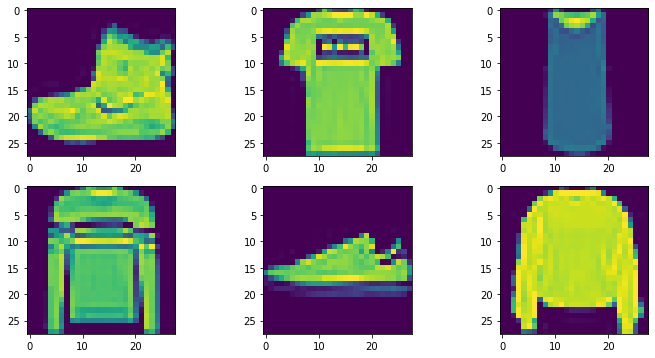

In [5]:
fig, ax = plt.subplots(2, 3, figsize=(12, 6))
ax[0, 0].imshow(train_images_gr[0].reshape(28,28))
ax[0, 1].imshow(train_images_gr[1].reshape(28,28))
ax[0, 2].imshow(train_images_gr[2].reshape(28,28))
ax[1, 0].imshow(train_images_gr[5].reshape(28,28))
ax[1, 1].imshow(train_images_gr[6].reshape(28,28))
ax[1, 2].imshow(train_images_gr[7].reshape(28,28))

print([class_names[i] for i in train_labels[:6]])

<h3>Building and Fine-Tuning a Pre-Trained ResNet101 Model</h3>
<br>
First some constants are set:
<br>
<br>
<code>EPOCHS</code>: Deals with how many times each batch size will be propagated through the net.
<br>
<br>
<code>BS</code>: Manages the how many images per batch will be propagated through the network.
<br>
<br>
<code>INPUT_SHAPE</code>: The dimensional shape of the images that the network will try to generalize.
<br>
<br>
<code>IMG_DIMS</code>: The dimension for the images to be accepted for the network.

In [6]:
EPOCHS = 16
BS = 64
INPUT_SHAPE = (32, 32, 3)
IMG_DIMS = (32, 32)

<p>
    Transfer learning is seeing unprecedented success in the world of computer vision and natural language processing with pre-trained models often outperforming training models from scratch. Here, a ResNet-101 model will be used which was pre-trained on the ImageNet dataset by fine-tuning it on the Fashion-MNIST dataset. The ResNet-101 model is a 101-convolutional block (several layers in each block) deep learning network built on the ImageNet database. This model has over 300+ layers in total and is a very deep network. ResNet stands for Residual Networks.
    <br>
    <br>
    The focus in this section will be taking the pre-trained ResNet-101 model and then perform complete fine-tuning of all the layers in the network. Later is going to be added a regular dense and output layers as usual.
</p>

In [7]:
def define_resnet50_model(input_shape):
    model = ResNet50(include_top=False,
                    weights='imagenet',
                    input_shape=input_shape)
    
    model.trainable = True
    return model

In [8]:
def define_resnet101_model(input_shape):
    model = ResNet101(include_top=False,
                    weights='imagenet',
                    input_shape=input_shape)
    
    model.trainable = True
    return model

In [9]:
def fine_tuning(model):
    for layer in model.layers:
        layer.trainable = True
    
    base_model = model
    base_out = base_model.output
    pool_out = k.layers.Flatten()(base_out)
    
    hidden_l1 = k.layers.Dense(512, activation='relu')(pool_out)
    drop_l1 = k.layers.Dropout(rate=0.3)(hidden_l1)
    hidden_l2 = k.layers.Dense(512, activation='relu')(drop_l1)
    drop_l2 = k.layers.Dropout(rate=0.3)(hidden_l2)
    
    out_layer = k.layers.Dense(10, activation='softmax')(drop_l2)
    
    model = k.Model(inputs=base_model.input, outputs=out_layer)
    
    return model

In [10]:
def compile_model(model):
    model.compile(optimizer=RMSprop(learning_rate=0.0001,
                                    rho=0.9),
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])
    return model

In [11]:
def build_model(input_shape, resnet):
    if resnet==50:
        model = define_resnet50_model(input_shape)
    else:
        model = define_resnet101_model(input_shape)
    model = fine_tuning(model)
    model = compile_model(model)
    
    model.summary()
    return model

In [12]:
model = build_model(INPUT_SHAPE, resnet=50)

/home/kleyer/anaconda3/envs/ai/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 16, 16, 64)   256         conv1[0][0]                      
____________________________________________________________________________________________

<p>
    The architecture of a <code>ResNet50</code> model is quite big but a  <code>ResNet101</code> architecture is enormous and it can be seen the evidence based on the number of trainable parameters. Before starting the train of the model, it is needed to convert the grayscale images into images with three channels since the <code>ResNet50</code> and <code>ResNet101</code> model was trained on color images. Besides that, the minimal dimensions acceptable by both models are 32x32 so we need to resize our images.    
</p>

In [13]:
def resize_image_array(img, img_size_dims):
    img = cv2.resize(img,
                    dsize=img_size_dims,
                    interpolation=cv2.INTER_CUBIC)
    img = np.array(img, dtype=np.float32)
    return img

In [14]:
def convert_3D_img_channel(train_set, test_set):
    train_3DSet = np.stack([train_set]*3, axis=-1)
    test_3DSet = np.stack([test_set]*3, axis=-1)
    
    return train_3DSet, test_3DSet

In [15]:
def resize_images(train_set, test_set):
    train_3DSet, test_3DSet = convert_3D_img_channel(train_set, test_set)
    train_3DSet = np.array([resize_image_array(img, img_size_dims=IMG_DIMS) for img in train_3DSet])
    test_3DSet = np.array([resize_image_array(img, img_size_dims=IMG_DIMS) for img in test_3DSet])
    
    return train_3DSet, test_3DSet

In [16]:
%%time
train_images, test_images = resize_images(train_set, test_set)

print('\nTrain_images.shape: {}, of {}'.format(train_images.shape, train_images.dtype))
print('Test_images.shape: {}, of {}'.format(test_images.shape, test_images.dtype))


Train_images.shape: (60000, 32, 32, 3), of float32
Test_images.shape: (10000, 32, 32, 3), of float32
CPU times: user 1.23 s, sys: 144 ms, total: 1.37 s
Wall time: 1.38 s


<p>
    Scale the training set.
</p>

In [17]:
def scaled_set(set):
    _set = set/255.
    return _set

<p>
    <h3>Incremental Learning</h3>
    <br>
    In some cases due to hardware capabilities it is imp/liosible to have an entire dataset loaded into the memory RAM or GPU memory, making imposible to train a Deep Learning or Machine Learning model, to resolve this issue there is the solution of <b>Incremental Learning</b>or sometimes called <b>Online Learning</b>.
    <br>
    <br>
    <b>Incremental Learning</b> enables to train a model on <i>small subsets of the data</i>, called <b>batches</b>. Using incremental learning the training process becomes:
    <ul>
        <li>Load a small batch of data from the dataset.</li>
        <li>Train the model on the batch.</li>
        <li>Repeat looping through the dataset in batches, training as it goes, until it reaches convergence.</li>
    </ul>
    <img src='images/IL_Diagram.png'>
    <br>
    The process <b>Incremental Learning</b> or <b>Online Learning</b> is <b>exactly how Neural Networks are trained</b>, Neural Networks are incremental learners such as humans brains.
</p>

<p>
    Train the model for 32 epochs.
</p>

In [19]:
model.fit(x=scaled_set(train_images),
         y=train_labels, 
         batch_size=BS,
         epochs=EPOCHS,
         verbose=1,
         callbacks=None,
         validation_split=0.1,
         validation_data=None,
         shuffle=True,
         class_weight=None,
         sample_weight=None,
         initial_epoch=0,
         steps_per_epoch=None,
         validation_steps=None,
         validation_freq=1,
         max_queue_size=10,
         workers=1,
         use_multiprocessing=True)


Train on 54000 samples, validate on 6000 samples
Epoch 1/16
54000/54000 [==============================] - 59s 1ms/step - loss: 0.5381 - accuracy: 0.8237 - val_loss: 0.8392 - val_accuracy: 0.7303
Epoch 2/16
54000/54000 [==============================] - 51s 937us/step - loss: 0.2788 - accuracy: 0.9073 - val_loss: 0.2489 - val_accuracy: 0.9182
Epoch 3/16
54000/54000 [==============================] - 51s 937us/step - loss: 0.2302 - accuracy: 0.9246 - val_loss: 0.2729 - val_accuracy: 0.9265
Epoch 4/16
54000/54000 [==============================] - 51s 946us/step - loss: 0.1971 - accuracy: 0.9355 - val_loss: 0.3440 - val_accuracy: 0.9235
Epoch 5/16
54000/54000 [==============================] - 51s 944us/step - loss: 0.1772 - accuracy: 0.9430 - val_loss: 0.3533 - val_accuracy: 0.9133
Epoch 6/16
54000/54000 [==============================] - 51s 947us/step - loss: 0.1554 - accuracy: 0.9508 - val_loss: 0.2574 - val_accuracy: 0.9283
Epoch 7/16
54000/54000 [==============================] - 

<p>
    <h4>Save the current models weights</h4>
    
</p>

In [18]:
def save_model(model, name):
    if not os.path.isdir('model_weights/'):
        os.mkdir('model_weights/')
    model.save_weights(filepath='model_weights/'+name, overwrite=True)

In [ ]:
save_model(model, 'resnet50_finetuned.h5')

In [23]:
# Predict
predictions = model.predict(scaled_set(test_images))
predictions_labels = np.argmax(predictions, axis=1)

In [24]:
print(classification_report(test_labels, predictions_labels, target_names=class_names))

              precision    recall  f1-score   support

 t-shirt/top       0.84      0.90      0.87      1000
     trouser       1.00      0.93      0.96      1000
    pullover       0.87      0.90      0.88      1000
       dress       0.90      0.93      0.91      1000
        coat       0.90      0.85      0.87      1000
      sandal       0.99      0.98      0.98      1000
       shirt       0.80      0.75      0.78      1000
     sneaker       0.95      0.99      0.97      1000
         bag       0.94      0.99      0.97      1000
  ankle boot       0.98      0.96      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



In [25]:
pd.DataFrame(confusion_matrix(test_labels, predictions_labels),
             index=class_names,
             columns=class_names)

t-shirt/top  trouser  pullover  dress  coat  sandal  shirt  \
t-shirt/top          900        0        14     15     1       0     65   
trouser                1      932         0     17     0       0      1   
pullover              22        0       898     11    28       0     41   
dress                 27        0         8    926    16       0     22   
coat                   2        0        61     36   846       0     55   
sandal                 1        0         0      0     0     976      0   
shirt                119        0        50     25    49       0    753   
sneaker                0        0         0      0     0       2      0   
bag                    5        0         0      1     0       1      1   
ankle boot             0        0         0      0     0       3      1   

             sneaker  bag  ankle boot  
t-shirt/top        0    5           0  
trouser            0   49           0  
pullover           0    0           0  
dress              0    1           0  
coat               0    0           0  
sandal            13    1           9  
shirt              0    4           0  
sneaker          987    0          11  
bag                1  991           0  
ankle boot        34    0         962

<p>
    <h4>Load the model</h4>
</p>

In [27]:
model = build_model(INPUT_SHAPE, resnet=101)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [28]:
model.fit(x=scaled_set(train_images),
         y=train_labels, 
         batch_size=BS,
         epochs=EPOCHS,
         verbose=1,
         callbacks=None,
         validation_split=0.1,
         validation_data=None,
         shuffle=True,
         class_weight=None,
         sample_weight=None,
         initial_epoch=0,
         steps_per_epoch=None,
         validation_steps=None,
         validation_freq=1,
         max_queue_size=10,
         workers=1,
         use_multiprocessing=True)

Train on 54000 samples, validate on 6000 samples
Epoch 1/16
54000/54000 [==============================] - 96s 2ms/step - loss: 0.5313 - accuracy: 0.8311 - val_loss: 1.0684 - val_accuracy: 0.7500
Epoch 2/16
54000/54000 [==============================] - 85s 2ms/step - loss: 0.2896 - accuracy: 0.9071 - val_loss: 4.9270 - val_accuracy: 0.8553
Epoch 3/16
54000/54000 [==============================] - 85s 2ms/step - loss: 0.2407 - accuracy: 0.9228 - val_loss: 0.7873 - val_accuracy: 0.9087
Epoch 4/16
54000/54000 [==============================] - 86s 2ms/step - loss: 0.2077 - accuracy: 0.9330 - val_loss: 0.2229 - val_accuracy: 0.9280
Epoch 5/16
54000/54000 [==============================] - 87s 2ms/step - loss: 0.1907 - accuracy: 0.9413 - val_loss: 0.4398 - val_accuracy: 0.9298
Epoch 6/16
54000/54000 [==============================] - 87s 2ms/step - loss: 0.1698 - accuracy: 0.9475 - val_loss: 0.4900 - val_accuracy: 0.9167
Epoch 7/16
54000/54000 [==============================] - 88s 2ms/ste

In [29]:
save_model(model, 'resnet101_finetuned.h5')

In [30]:
# Predict
predictions = model.predict(scaled_set(test_images))
predictions_labels = np.argmax(predictions, axis=1)

In [32]:
print(classification_report(test_labels, predictions_labels, target_names=class_names))

              precision    recall  f1-score   support

 t-shirt/top       0.86      0.88      0.87      1000
     trouser       1.00      0.98      0.99      1000
    pullover       0.83      0.90      0.86      1000
       dress       0.93      0.93      0.93      1000
        coat       0.89      0.84      0.87      1000
      sandal       0.98      0.98      0.98      1000
       shirt       0.78      0.77      0.77      1000
     sneaker       0.96      0.97      0.97      1000
         bag       0.99      0.97      0.98      1000
  ankle boot       0.97      0.98      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



In [31]:
pd.DataFrame(confusion_matrix(test_labels, predictions_labels),
             index=class_names,
             columns=class_names)

t-shirt/top  trouser  pullover  dress  coat  sandal  shirt  \
t-shirt/top          883        0        22     11     0       0     82   
trouser                1      979         3     11     1       0      4   
pullover              12        0       897      8    30       0     53   
dress                 14        1        13    927    19       0     26   
coat                   1        0        90     21   842       0     46   
sandal                 0        0         0      0     0     977      0   
shirt                110        0        49     16    54       0    768   
sneaker                0        0         0      0     0       3      0   
bag                    5        1         2      4     0      10      6   
ankle boot             1        0         0      0     0       4      0   

             sneaker  bag  ankle boot  
t-shirt/top        0    2           0  
trouser            0    1           0  
pullover           0    0           0  
dress              0    0           0  
coat               0    0           0  
sandal            17    0           6  
shirt              0    3           0  
sneaker          972    0          25  
bag                2  970           0  
ankle boot        17    0         978

In [19]:
def load_model(input_shape, name):
    if name == 'resnet50_finetuned.h5':
        model = build_model(input_shape, 50)
        model.load_weights('model_weights/resnet50_finetuned.h5')
    else:
        model = build_model(input_shape, 101)
        model.load_weights('model_weights/resnet101_finetuned.h5')
    return model 

<p>
    <h2>Saving models for TensorFlow Serving</h2>
    <br>
    For serving models using TensorFlow Serving it is needed to save them into the <code>SavedModel</code> format, this can be achieved by using the function <code>tf.saved_model.simple_save(...)</code>, this will be demostrated in the bellow cell.
</p>

In [17]:
model_resnet50 = load_model(INPUT_SHAPE, 'resnet50_finetuned.h5')

/home/kleyer/anaconda3/envs/ai/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 16, 16, 64)   256         conv1[0][0]                      
____________________________________________________________________________________________

In [18]:
model_resnet101 = load_model(INPUT_SHAPE, 'resnet101_finetuned.h5')

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [20]:
def tf_saved_model_simple_save(model, numModel):
    export_path = './tf_saved_models/' + str(numModel)
    tf.compat.v1.saved_model.simple_save(
        k.backend.get_session(),
        export_path,
        inputs={'input_image': model.input},
        outputs={t.name:t for t in model.outputs})

In [21]:
tf_saved_model_simple_save(model_resnet50, 1)

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.simple_save.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: ./tf_saved_models/1/saved_model.pb


In [22]:
tf_saved_model_simple_save(model_resnet101, 2)

INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: ./tf_saved_models/2/saved_model.pb


In [21]:
# View saved models
! tree --du -h .

.
├── [1.6M]  images
│   ├── [ 92K]  1.jpg
│   ├── [339K]  1.png
│   ├── [ 18K]  Export_M.png
│   ├── [672K]  FMNIST.png
│   ├── [ 20K]  IL_Diagram.png
│   ├── [ 27K]  model_config.png
│   ├── [ 38K]  MS_Approach.png
│   ├── [264K]  request_simple_diagram.png
│   ├── [ 76K]  serving_TFS.png
│   └── [ 89K]  TFS_ArchCore.png
├── [262K]  introduction_to_tensorflow_serving.ipynb
├── [ 309]  models_config.conf
├── [264M]  model_weights
│   ├── [169M]  resnet101_finetuned.h5
│   └── [ 95M]  resnet50_finetuned.h5
├── [ 849]  my.png
├── [4.2K]  server.log
└── [533M]  tf_saved_models
    ├── [267M]  1
    │   ├── [3.7M]  saved_model.pb
    │   └── [263M]  variables
    │       ├── [263M]  variables.data-00000-of-00001
    │       └── [ 34K]  variables.index
    └── [267M]  2
        ├── [4.1M]  saved_model.pb
        └── [263M]  variables
            ├── [263M]  variables.data-00000-of-00001
            └── [ 34K]  variables.index

 799M used in 7 directories, 22 files


<p>
    Tensorflow's <code>SavedModel</code> command line interface tool, <code>saved_model_cli</code>, it is useful to quickly inspect the input and output specificationd of a model, this shows details pertaining to the selected model.
    <br>
    <br>
    The below output shows details pertaining to the seconde model, the one that has been build with the <code>ResNet101</code> architecture, including its input and output specifications.
</p>

In [20]:
!export PYTHONWARNINGS='ignore' && saved_model_cli show --dir {'./tf_saved_models/1'} --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['input_image'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 32, 32, 3)
        name: input_1:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['dense_3/Softmax:0'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 10)
        name: dense_3/Softmax:0
  Method name is: tensorflow/serving/predict


<p>
    <h2>Serving models with CPU Inference</h2>
    <br>
    In this part is going to be demostrated how to serve the saved models using TensorFlow Serving leveraging in the CPU, through a local installation in the system and a <a href='https://www.tensorflow.org/tfx/serving/docker'>Docker installation based setup</a> for TensorFlow Serving, this container is easier to maintend up to date and use, because there is not need of set up any configurations or dependencies.
</p>

In [52]:
!docker pull tensorflow/serving

Using default tag: latest
latest: Pulling from tensorflow/serving
Digest: sha256:f7e59a29cbc17a6b507751cddde37bccad4407c05ebf2c13b8e6ccb7d2e9affb
Status: Image is up to date for tensorflow/serving:latest
docker.io/tensorflow/serving:latest


<p>
    These next steps are for installing and setting up TensorFlow Serving locally.
    <h3>Install TensorFlow Serving</h3>
    <br>
    Note this only consists of the CPU version, to start we add the source to obtain TensorFlow Serving.
</p>

In [53]:
!echo "deb [arch=amd64] http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" \
| sudo tee /etc/apt/sources.list.d/tensorflow-serving.list && \
curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg \| sudo apt-key add -

<p>
    Next, if there is any existing version of TensorFlow Serving it has to be removed, this can be donde by executing the next command.
</p>

In [ ]:
!sudo apt-get -y remove tensorflow-model-server

<p>
    Now TensorFlow Serving is going to be installed by the following command.
</p>

In [ ]:
!sudo apt-get update && sudo apt-get install tensorflow-model-server

<p>
    For last TensorFlow Serving is going to be installed by the execution of the below command.
</p>

<p>
    <h2>Start Serving Models with TensorFlow Serving</h2>
    <br>
    It is necessary to setup a model serving config file if it is wanted to customize the number of models that may be served and other advance configurations. The configuration file is simple and depicted in the following snippet which is stored in <code>models_config.conf</code>, note that both models are intended to be served, therefore the config file helps in making this process easier.
    <br>
    <img src='images/model_config.png' width=400px height=350px>
    <br>
</p>

In [28]:
!/usr/bin/tensorflow_model_server --version

TensorFlow ModelServer: 1.14.0-rc0+dev.sha.34d9e85
TensorFlow Library: 1.14.0


In [29]:
%%bash --bg
nohup /usr/bin/tensorflow_model_server \
    --rest_api_port=8501 \
    --model_config_file='/home/kleyer/Software_Engineering_Projects/Tensorflow_Serving/models.conf' >server.log 2>&1

In [55]:
#! tensorflow_model_server --rest_api_port=8502 --model_config_file='/home/kleyer/Software_Engineering_Projects/Tensorflow_Serving/models_config.conf' >server.log 2>&1

In [31]:
# checking the logs
!tail server.log

2019-10-12 12:58:30.946733: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:202] Restoring SavedModel bundle.
2019-10-12 12:58:31.688960: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:311] SavedModel load for tags { serve }; Status: success. Took 1084342 microseconds.
2019-10-12 12:58:31.689004: I tensorflow_serving/servables/tensorflow/saved_model_warmup.cc:103] No warmup data file found at /home/kleyer/Software_Engineering_Projects/Tensorflow_Serving/tf_saved_models/1/assets.extra/tf_serving_warmup_requests
2019-10-12 12:58:31.689083: I tensorflow_serving/core/loader_harness.cc:86] Successfully loaded servable version {name: fashionmnist_model_serving version: 1}
2019-10-12 12:58:31.690562: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:311] SavedModel load for tags { serve }; Status: success. Took 1185340 microseconds.
2019-10-12 12:58:31.690585: I tensorflow_serving/servables/tensorflow/saved_model_warmup.cc:103] No warmup data file foun

<p>
    It can be seen by the server log messages that our server has successfully loaded both the models and they are ready for serving.
    <br>
    <h3>Serving Model Inference Requests</h3>
    <br>
    The models are ready for being served, with serving model inference requests using the first model, the basic <code>ResNet50</code>.
</p>

In [32]:
# Get some sample data
sample_test_data = test_set[500:510]
sample_test_labels = test_labels[500:510]

In [33]:
# Pre-processs data
IMG_DIMS = (32, 32)
sample_test_data_processed = scaled_set(np.array([resize_image_array(img, IMG_DIMS)
                                                 for img in np.stack([sample_test_data]*3, axis=-1)]))

In [36]:
# Create Payload
DATA = json.dumps({'signature_name': 'serving_default',
                  'instances':sample_test_data_processed.tolist()})

HEADERS = {'content-type': 'application/json'}
MODEL_RESNET50_API_URL = 'http://localhost:8501/v1/models/fashionmnist_model_serving/versions/1:predict'

In [37]:
# Inference Request
json_response = requests.post(MODEL_RESNET50_API_URL, data=DATA, headers=HEADERS)

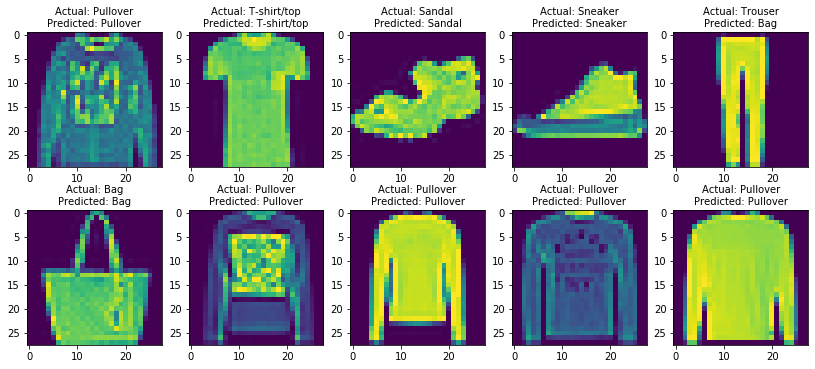

In [38]:
# View Server Response
predictions = json.loads(json_response.text)['predictions']
predictions = np.argmax(np.array(predictions), axis=1)
prediction_labels = [class_names[p] for p in predictions]

#plt.imshow((out * 255).astype(np.uint8))

fig, ax = plt.subplots(2, 5, figsize=(14, 6))
for idx, img in enumerate(sample_test_data):
    rowidx = idx // 5
    colidx = idx % 5
    ax[rowidx, colidx].imshow(img)
    ax[rowidx, colidx].set_title('Actual: {}\nPredicted: {}'.format(class_names[sample_test_labels[idx]], prediction_labels[idx]), fontsize=10)
    

<p>
    The models is working well, it is serving requests and making predictions as expected.
    <br>
    <h2>Model WarmUps</h2>
    <br>
    When a model is being in production and serving, an important thing to remember is that the TensorFlow runtime has components that are lazily initialized, This latency can be several orders of magnitude higher than that of a single inference request. Hence it is good to warmup the models by sending a few sample records as an initial request after loading the model. This can be done at model load time by checking out the <a href='https://www.tensorflow.org/tfx/serving/saved_model_warmup'>following documentation</a>.
    <br>
    <br>
    This is a simple approach of sending a sample request to each of our models to warm it up after it is loaded, for doing this there has to be some save sample data in a file which it can be loaded and use later for warming up the models, this is going to be implemented in the next cell bellow.
</p>

In [115]:
# Save Sample Data
np.save('serve_warmup_data.npy', sample_test_data)
np.save('serve_warmup_labels.npy', sample_test_labels)

In [21]:
def warmup_process(warmup_data,  warmup_labels, MODEL_API_URL, architecture, img_dims=(32, 32)):
    try:
        warmup_data_processed = (np.array([resize_image_array(img, img_size_dims=img_dims) 
                                               for img in np.stack([warmup_data]*3, axis=-1)])) / 255.
        data = json.dumps({"signature_name": "serving_default", 
                           "instances": warmup_data_processed.tolist()})

        HEADERS = {'content-type': 'application/json'}
        
        json_response = requests.post(MODEL_API_URL, data=data, headers=HEADERS)
    except requests.exceptions.HTTPError as e:
        print('Json Response Error: {}' .format(e))
    else:
        predictions = json.loads(json_response.text)['predictions']
        print('Model ResNet{} warmup complete'.format(architecture))
        predictions = np.argmax(np.array(predictions), axis=1)
        print(classification_report(warmup_labels, predictions))


In [14]:
# Model Warmup functions
def warmup_modelResNet(port, warmup_data, warmup_labels, architecture):
    MODEL_RESNET_API_URL = 'http://localhost:' + str(port) + '/v1/models/fashionmnist_model_serving/versions/'
    if architecture==50:
        MODEL_RESNET_API_URL = MODEL_RESNET_API_URL + str('1:predict')
        warmup_process(warmup_data=warmup_data, warmup_labels=warmup_labels, MODEL_API_URL=MODEL_RESNET_API_URL, architecture=architecture)
    elif architecture==101:
        MODEL_RESNET_API_URL = MODEL_RESNET_API_URL + str('2:predict')
        warmup_process(warmup_data=warmup_data, warmup_labels=warmup_labels, MODEL_API_URL=MODEL_RESNET_API_URL, architecture=architecture)
    else:
        print('Architecture {} does not exist for a ResNet model.' .format(architecture))                

In [41]:
# WarmUp Models
warmup_data = np.load('serve_warmup_data.npy')
warmup_labels = np.load('serve_warmup_labels.npy')

warmup_modelResNet(8501, warmup_data, warmup_labels, 50)
warmup_modelResNet(8501, warmup_data, warmup_labels, 101)

Model ResNet50 warmup complete
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       0.00      0.00      0.00         1
           2       1.00      1.00      1.00         5
           5       1.00      1.00      1.00         1
           7       1.00      1.00      1.00         1
           8       0.50      1.00      0.67         1

    accuracy                           0.90        10
   macro avg       0.75      0.83      0.78        10
weighted avg       0.85      0.90      0.87        10

Model ResNet101 warmup complete
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       0.00      0.00      0.00         1
           2       1.00      1.00      1.00         5
           5       1.00      1.00      1.00         1
           7       1.00      1.00      1.00         1
           8       0.50      1.00      0.67         1

    accuracy  

/home/kleyer/anaconda3/envs/ai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


<p>
    <h2>Benchmarking Model Serving Requests</h2>
    <br>
    It is good to compare how many time and resources do models need to serve their inference/predictions request for a batch of images, for this the 10K images from the test set. Do note that is being send only a single request and seeing the inference time of the whole batch. In the next section multiple requests will be send to check up the inference time taken by the models.
</p>

In [138]:
%%time
warmup_modelResNet(8501, test_set, test_labels, 50)
len(test_labels)

Model ResNet50 warmup complete
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1000
           1       1.00      0.93      0.96      1000
           2       0.87      0.90      0.88      1000
           3       0.90      0.93      0.91      1000
           4       0.90      0.85      0.87      1000
           5       0.99      0.98      0.98      1000
           6       0.80      0.75      0.78      1000
           7       0.95      0.99      0.97      1000
           8       0.94      0.99      0.97      1000
           9       0.98      0.96      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000

CPU times: user 18.6 s, sys: 865 ms, total: 19.5 s
Wall time: 32.9 s


10000

<p>
    The model of the architecture  <code>ResNet50</code> was able to serve the request of inference for 10000 images in around 34 seconds which is pretty good considering the model performed the inference using a CPU. Now it is time to check out the performance of the second model the <code>ResNet101</code>.
</p>

In [139]:
%%time
warmup_modelResNet(8501, test_set, test_labels, 101)
len(test_labels)

Model ResNet101 warmup complete
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1000
           1       1.00      0.93      0.96      1000
           2       0.87      0.90      0.88      1000
           3       0.90      0.93      0.91      1000
           4       0.90      0.85      0.87      1000
           5       0.99      0.98      0.98      1000
           6       0.80      0.75      0.78      1000
           7       0.95      0.99      0.97      1000
           8       0.94      0.99      0.97      1000
           9       0.98      0.96      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000

CPU times: user 19.4 s, sys: 885 ms, total: 20.3 s
Wall time: 33.6 s


10000

<p>
    The model <code>ResNet101</code> takes a little bit more of time, even thouhg its avg accuracy it is similar to the model of <code>ResNet50</code>, <b>depth of a network architecture does not allways improve inference results</b>.
    <br>
    <h2>Serving Models with Docker for GPU Inference</h2>
    <br>
    Serving models with TensorFlow Serving by GPU inferences, this will be done by running the docker image which will be downloaded by the execution of the bellow cell, some Data Scientiest and Engineers consider that it is better to run the commnad from the terminal and not from a Jupyter Notebook cell.
</p>

In [16]:
!docker pull tensorflow/serving:latest-gpu

latest-gpu: Pulling from tensorflow/serving
Digest: sha256:fd54edb56a7bc72ea0606ed03b7de7d3cfb8a2143e797187555a78b37ff7c49a
Status: Image is up to date for tensorflow/serving:latest-gpu
docker.io/tensorflow/serving:latest-gpu


In [17]:
!docker images

REPOSITORY           TAG                 IMAGE ID            CREATED             SIZE
nvidia/cuda          10.0-base           5026b20f9c3d        6 weeks ago         110MB
tensorflow/serving   latest-gpu          b247542eae94        3 months ago        2.42GB


<p>
    The bash command in the next cell is the one will start Tensorflow Serving for GPU Inference.
    <br>
    <br>
    If there is an error it may be because the port <code>8501</code> is being used, to check up if this port is being used the next command can be helpful:
    <br>
    <code>sudo ss -i | grep :<i>PORT_NUMBER</i></code>
    <br>
    And if the port is being used it can be closed by the next command:
    <br>
    <code>sudo kill $(sudo lsof -t -i :<i>PORT_NUMBER</i>)</code>
</p>

In [23]:
%%bash --bg
docker run --runtime=nvidia -p 8501:8501 --mount type=bind,source=/home/kleyer/Software_Engineering_Projects/Tensorflow_Serving/tf_saved_models,target=/home/kleyer/Software_Engineering_Projects/Tensorflow_Serving/tf_saved_models --mount type=bind,source=/home/kleyer/Software_Engineering_Projects/Tensorflow_Serving/models.conf,target=/home/kleyer/Software_Engineering_Projects/Tensorflow_Serving/models.conf -t tensorflow/serving:latest-gpu --model_config_file=/home/kleyer/Software_Engineering_Projects/Tensorflow_Serving/models.conf

<p>
    The command bellow works for checking up if the container is up and running.
</p>

In [19]:
! docker ps -all

CONTAINER ID        IMAGE                           COMMAND                  CREATED             STATUS              PORTS                              NAMES
293a381aa588        tensorflow/serving:latest-gpu   "/usr/bin/tf_serving…"   About an hour ago   Up About an hour    8500/tcp, 0.0.0.0:8501->8501/tcp   lucid_payne


In [84]:
! docker restart 293a381aa588

Error response from daemon: Cannot restart container 1f283a6a32a9: driver failed programming external connectivity on endpoint inspiring_gates (58d3e79b257b9a03da6f400679c7bd0cd2b8771f523bc56786dec6fdc6bc2ce2): Bind for 0.0.0.0:8501 failed: port is already allocated


<p>
    In case that checking up the logs in Docker to verify everything is working perfectly.
    <br>
    <br>
    <code>docker logs <i>Container ID  Names</i> | tail -n 15</code>
</p>

In [25]:
!docker logs 2dc5fa67d520 | tail -n 15

<p>
    This verifies the fact that TensorFlow Serving will be using the GPU of the system for inference.
    <h2>Model WarmUp with GPU</h2>
    <br>
    The previously implemented code to warmup the <code>ResNet</code> models.
</p>

In [90]:
%%time
warmup_modelResNet(8501, warmup_data, warmup_labels, 50)

Model ResNet50 warmup complete
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       0.00      0.00      0.00         1
           2       1.00      1.00      1.00         5
           5       1.00      1.00      1.00         1
           7       1.00      1.00      1.00         1
           8       0.50      1.00      0.67         1

    accuracy                           0.90        10
   macro avg       0.75      0.83      0.78        10
weighted avg       0.85      0.90      0.87        10

CPU times: user 26.4 ms, sys: 372 µs, total: 26.7 ms
Wall time: 41.8 ms


In [91]:
%%time
warmup_modelResNet(8501, warmup_data, warmup_labels, 101)

Model ResNet101 warmup complete
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       0.00      0.00      0.00         1
           2       1.00      1.00      1.00         5
           5       1.00      1.00      1.00         1
           7       1.00      1.00      1.00         1
           8       0.50      1.00      0.67         1

    accuracy                           0.90        10
   macro avg       0.75      0.83      0.78        10
weighted avg       0.85      0.90      0.87        10

CPU times: user 23.2 ms, sys: 3.7 ms, total: 26.9 ms
Wall time: 41.6 ms


<p>
    It can be seen that the model warming up don't last more than a second, which it is impresive!, now a benchmarking test is going to be done using GPU inference to see if inference through GPU is faster than the inference done through CPU.
    <h2>Benchmarking Model Serving Request</h2>
    <br>
    The full set for testing will be the one that is going to be used to perform this benchmark, all of the 10K test images will be send as a single request to check model serving time for inference using GPU.
<p>

In [98]:
%%time
warmup_modelResNet(8501, test_set, test_labels, 50)

Model ResNet50 warmup complete
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1000
           1       1.00      0.93      0.96      1000
           2       0.87      0.90      0.88      1000
           3       0.90      0.93      0.91      1000
           4       0.90      0.85      0.87      1000
           5       0.99      0.98      0.98      1000
           6       0.80      0.75      0.78      1000
           7       0.95      0.99      0.97      1000
           8       0.94      0.99      0.97      1000
           9       0.98      0.96      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000

CPU times: user 18.9 s, sys: 807 ms, total: 19.7 s
Wall time: 23.7 s


In [96]:
%%time
warmup_modelResNet(8501, test_set, test_labels, 101)

Model ResNet101 warmup complete
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1000
           1       1.00      0.93      0.96      1000
           2       0.87      0.90      0.88      1000
           3       0.90      0.93      0.91      1000
           4       0.90      0.85      0.87      1000
           5       0.99      0.98      0.98      1000
           6       0.80      0.75      0.78      1000
           7       0.95      0.99      0.97      1000
           8       0.94      0.99      0.97      1000
           9       0.98      0.96      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000

CPU times: user 19 s, sys: 749 ms, total: 19.8 s
Wall time: 24 s


<p>
    It is clearly that inference using GPU yields faster results, with an average of 23-24 secondos in both <code>ResNet</code> architectures, it is almost 10 seconds less than inference done through CPU.
    <br>
    <br>
    <h2>A Real Benchmarking Test</h2>
    <br>
    For this part what is going to be done is that every single sample that forms the test set is going to be taken to perform separate and individual requests for inference of a single apparel image to be classified each time. Is TensorFlow Serving going to serve these 10k requests fast?
</p>

In [103]:
# Create Serving Function
def predict_appareal(img, img_dims=(32, 32), label_map=class_names):
    sample_img_processed = (np.array([resize_image_array(img, img_size_dims=img_dims) for img in np.stack([[img]]*3, axis=-1)])) / 255.
    data = json.dumps({"signature_name": "serving_default", 
                       "instances": sample_img_processed.tolist()})
    
    HEADERS = {'content-type': 'application/json'}
    MODEL_API_URL = 'http://localhost:8501/v1/models/fashionmnist_model_serving/versions/1:predict'
    json_response = requests.post(MODEL_API_URL, data=data, headers=HEADERS)
    prediction = json.loads(json_response.text)['predictions']
    prediction = np.argmax(np.array(prediction), axis=1)[0]
    return label_map[prediction]

<b>Benchmark 10K requests!</b>

In [109]:
%%time

pred_labels = []
for img in test_set:
    pred_label = predict_appareal(img)
    pred_labels.append(img)

len(pred_labels)

CPU times: user 40.9 s, sys: 867 ms, total: 41.8 s
Wall time: 2min


10000

<p>
    The total taken was of <b>120</b> seconds to serve 10000 requests, with an average of <b>12</b> seconds for each request, using the native model prediction API showcases the need and importance of leveraging TensorFlow Serving especially when models are in production.
    <br>
    <h2>Building an Apparel Classifier API with Flask + TensorFlow Serving + Gunicorn</h2>
    <br>
    <img src='images/API_FLASK_GUNICORN_TF.png'/>
    <br>
    It has been demostrated how useful TensorFlow Serving is providing a high performance system to serve inference requests. For building an API it is necessary to have access to the image data, preprocess it and then send it in an appropriate format to TensorFlow Serving, therefor once the response is delivered from TensorFlow Serving API, it is necessary to access the class probabilities, get the class with the maximum probability and then get the corresponding apparel class label.
    <br>
    <br>
    The most appropriate way to accomplish all these steps is to leverage a robust framework like Flask to build a web service or API on top of TensorFlow Serving to accept images from the client side (real world), perform necessary pre-processing, call TensorFlow Serving, post-process the response and then send the final JSON response to the end-user.
    <br>
    <br>
    <code><b>Note</b>: It is possible to dockerize and deploy the Flask API on Kubernetes or use a WSGI server like Gunicorn to scale and improve performance.</code>
    <br>
    <br>
    <h2>Create API with Flask</h2>
    <br>
    This part starts with the necessary code to create the apparel API leveraging Flask, this code will be save in a file named <b>app.py</b>.
<p>    

In [12]:
# Load dependencies
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import requests
import base64
import json
from io  import BytesIO
from flask import Flask, request, jsonify
from flask_cors import CORS
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
import cv2

In [2]:
# TensorFlow Serving Assets
HEADERS = {'content-type':'application/json'}
MODEL_API_URL = 'http://localhost:8501/v1/models/fashionmnist_model_serving/versions/1:predict'
CLASS_NAMES = ['T-shirt/top',
               'Trouser',
               'Pullover',
               'Dress',
               'Coat',
               'Sandal',
               'Shirt',
               'Sneaker',
               'Bag',
               'Ankle boot']

In [3]:
# Instantiate Flask App
app = Flask(__name__)
CORS(app)

In [4]:
# Image resizing utils
def resize_image_array(img, img_size_dims):
    img = cv2.resize(img,
                     dsize=img_size_dims,
                     interpolation=cv2.INTER_CUBIC)
    img = np.array(img, dtype=np.float32)
    return img

In [11]:
# Model warmup function
def warmup_model_serve(warmup_data, warmup_labels, img_dims=(32, 32)):
    warmup_data_processed = (np.array([resize_image_array(img, 
                                                          img_size_dims=img_dims) 
                                            for img in np.stack([warmup_data]*3, 
                                                                axis=-1)])) / 255.
    data = json.dumps({"signature_name": "serving_default", 
                       "instances": warmup_data_processed.tolist()})

    json_response = requests.post(MODEL_API_URL, data=data, headers=HEADERS)
    predictions = json.loads(json_response.text)['predictions']
    print('Model warmup complete') # log this in actual production
    predictions = np.argmax(np.array(predictions), axis=1)
    print(classification_report(warmup_labels, predictions))
    

In [13]:
# TensorFlow Serving lazy loads so the model can be warmed up with sample data
# This runs as soon as the web service is set up to run
warmup_data = np.load('serve_warmup_data.npy')
warmup_labels = np.load('serve_warmup_labels.npy')
warmup_model_serve(warmup_data, warmup_labels)

Model warmup complete
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       0.00      0.00      0.00         1
           2       1.00      1.00      1.00         5
           5       1.00      1.00      1.00         1
           7       1.00      1.00      1.00         1
           8       0.50      1.00      0.67         1

    accuracy                           0.90        10
   macro avg       0.75      0.83      0.78        10
weighted avg       0.85      0.90      0.87        10



/home/kleyer/anaconda3/envs/ai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [15]:
# Liveness Test
@app.route('/apparel_classifier/api/v1/liveness', methods=['GET', 'POST'])
def liveness():
    return 'API Live!'  

In [16]:
# Model Inference Endpoint
@app.route('/apparel_classifier/api/v1/model_predict', methods=['POST'])
def image_classifier():
    img = np.array([keras.preprocessing.image.img_to_array(
            keras.preprocessing.image.load_img(BytesIO(base64.b64decode(request.form['b64_img'])),
                                               target_size=(32, 32))) / 255.])

    data = json.dumps({"signature_name": "serving_default", 
                       "instances": img.tolist()})
    
    json_response = requests.post(MODEL_API_URL, data=data, headers=HEADERS)
    prediction = json.loads(json_response.text)['predictions']
    prediction = np.argmax(np.array(prediction), axis=1)[0]
    prediction = CLASS_NAMES[prediction]

    return jsonify({'apparel_type': prediction})

In [18]:
# Running REST interface, port=5000 for direct test use debug=True when debugging
if __name__ == '__main__':
    app.run(debug=False, host='0.0.0.0', port=5000)

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://0.0.0.0:5000/ (Press CTRL+C to quit)


<p>
    <code><b>Note</b>: This code it is stored in a file named <i>app.py</i>.</code>
    <br>
    <h3>Start Docker Container for TensorFlow Serving</h3>
    <br>
    Check and restart the docker container for TensorFlow Serving if it’s not already up and running
</p>

In [20]:
!docker start 293a381aa588
!docker ps -all

293a381aa588
CONTAINER ID        IMAGE                           COMMAND                  CREATED             STATUS              PORTS                              NAMES
293a381aa588        tensorflow/serving:latest-gpu   "/usr/bin/tf_serving…"   About an hour ago   Up About an hour    8500/tcp, 0.0.0.0:8501->8501/tcp   lucid_payne


<p>
    <h3>Start our Apparel Classifier Web Service</h3>
    <br>
    Let's start the web service. In production, it is recommended to NOT use the default web server provided by Flask but a better production-ready WSGI server, just like Gunicorn. Now it is the time to start the web service using the following command from the terminal.
    <br>
    <br>
    <code>gunicorn -b 0.0.0.0:5000 app:app -w 8</code>
    <br>
    <img src='images/FLASK_TFS_GUNICORN_APP_RUN.png'>
    <br>
    Multiple workers are leveraged to serve more request as needed. Now it is necessary to check if the API is live using the liveness test endpoint.
</p>

In [21]:
r = requests.get('http://0.0.0.0:5000/apparel_classifier/api/v1/liveness')
r.status_code, r.text

(200, 'API Live!')

<p>
    <h2>Serve Sample Apparel Classification with Web Service</h2>
    <br>
    It is time to take a sample real-world image and try to use the web service for performing classification. The image is depicted with the following code.
</p>

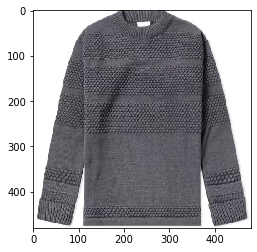

In [4]:
plt.imshow(cv2.cvtColor(cv2.imread('images/APPAREL_SWEATER.jpg'),    
                        cv2.COLOR_BGR2RGB))

<p>
    It is the image of a sweater. Let's leverage the API to serve the model prediction, it is necessary to encode any input image to the Base64 format and then decoding itand pre-processing the same in the server side before performing model inference.
<p>

In [5]:
import base64
import requests

with open('images/APPAREL_SWEATER.jpg', 'rb') as imageFile:
    img_b64enc = base64.b64encode(imageFile.read())
    data = {'b64_img': img_b64enc}

API_URL = 'http://0.0.0.0:5000/apparel_classifier/api/v1/model_predict'
# sending post request and saving response as response object
r = requests.post(url=API_URL, data=data)
r.json()

{'apparel_type': 'Pullover'}

<p>
    An answer from the API in JSON format!.
    <br>
    The image it is clearly right classified by the model. The API is returning the apparel category in the form of a JSON response.
    <br>
    <h3>Benchmark the  Web Service</h3>
    <br>
    Considering web server latency, image processing, model inference and serving, let’s check out how much time it takes to process 10000 requests now.
</p>

In [7]:
%%time
API_URL = 'http://0.0.0.0:5000/apparel_classifier/api/v1/model_predict'
responses = []
for i in range(10000):
    # sending post request and saving response as response object
    r = requests.post(url=API_URL, data=data)
    responses.append(r.json())
len(responses)

CPU times: user 58.7 s, sys: 1.22 s, total: 60 s
Wall time: 4min 17s


10000

In [8]:
print('Inference time per image: {} ms'.format(((4*60 + 17) / 10000) * 1000)) 

Inference time per image: 25.7 ms


<p>
    The API is able to serve each request in <b>25.7</b> ms which is not too bad.
    <br>
    <h2>Conclusion</h2>
    <br>
   This notebook gives an idea about how building models and prototyping for the real-world. It is good to have in mind the complete end-to-end picture even when training personal models. This helps to envision and implement own inference system much faster once the models are trained. This also gives an idea that while TensorFlow Serving might seem complex, once started with it, you can train, save and serve your models pretty easily and it works well with frameworks like Docker, Flask, Kubernetes and so on.
</p>